# PCA, ICA, and UMAP

In [3]:
suppressWarnings(require('pkgmaker',quietly = T))
require('plyr',quietly = T)
l_ply(c('dplyr',
        'data.table',
        'tidyr',  
        'tibble',
        'jsonlite', 
        'rjson',
        'httr', 
        'tidyverse', 
        'ggplot2', 
        'viridis', 
        'umap', 
        'FactoMineR'), function(pkg) {
          invisible(capture.output(irequire(pkg, quiet = T, autoinstall = T)))
        })

## Data

Uncomment the following to request the data via API.

In [1]:
# # In "gene_list.csv", define a list of genes of interest
# gene_list  <- as.list(read.csv("gene_list.csv")$x)
# gene_list[1:2]

In [9]:
# # Define the data to query from API
# data  <- list("request_data_type" = "expression",
#   "request_cancer_type" = c("Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", 
#                             "Thyroid", "Testicular", "Hepatocellular carcinoma", "Melanoma"),
# #   "request_genes" = c("ATM", "BRCA1", "BRCA2", "BRIP1", "CDK12", "FANCA", "HDAC2", "KRAS", 
# #                       "PALB2", "SRY", "TP53", "NOTCH1", "CCND1", "BARD1", "FBLN2", "CDKN1B", 
# #                       "RB1", "CHEK2", "APOBEC3B", "PALB2"),  # to define a list of genes here
#   "request_genes" = gene_list,  # if a list of genes is defined in a file
#   "request_dataset" = "PDX",
#   "request_key" = "---",  # enter your token here
#   "request_client" = 99,
#   "request_user" = 1234,  # enter your user id here
#   "request_workspace_id" = "1234-99",  # enter your user id "XXXX-99"
#   "request_mode" = 'true')

In [10]:
# # Request data from API - this may take some time
# request  <-  POST(url = 'https://lumin-fast-api.championsoncology.com/WS', 
#                   body = data, encode = 'json')
# request
# # A successful request will give "Status: 200"

Response [https://lumin-fast-api.championsoncology.com/workstation]
  Date: 2021-10-15 19:00
  Status: 200
  Content-Type: application/json
  Size: 75 B


In [11]:
# # This will save the data file as a .json file in your root directory
# response <- content(request)
# response

[1] "success, the file you may view your requested data in your root directory"

After requesting the data from API, use the following to read in the data.

In [4]:
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---19-10-2021---20_44_20.json")

In [40]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$gene  <- as.character(df$gene)
df$model  <- as.character(df$model)
df$log.tpm  <- as.numeric(df$log.tpm)
df$tumor_type <- as.character(df$tumor_type)
head(df, 2)
print(dim(df))

v1,gene_id,log.rsem.rpkm,log.tpm,z,fold,trans,model,sort_key,gene,model_name,tumor_type
19463231,ENSG00000005187,2.03154538924124,2.7411490,-0.169317194943646,0.876569685689051,ENST00000440284:49.26% ENST00000567387:17.78% ENST00000501740:11.52% ENST00000289416:10.09%,CTG-3501,CTG-3501_Expression_1,ACSM3,CTG-3501,Breast
19463234,ENSG00000005243,0.43494348437293,0.7995996,-0.994615041230675,0.185174375597962,ENST00000006101:78.76% ENST00000579263:20.8%,CTG-3501,CTG-3501_Expression_1,COPZ2,CTG-3501,Breast


[1] 82800    12


In [6]:
# Pivot the data
log_tpm <- df %>% 
    select(c('gene', 'model', 'log.tpm'))  %>% 
    pivot_wider(names_from = gene, values_from = log.tpm)  %>% 
    column_to_rownames('model')
log_tpm  <- log_tpm[complete.cases(log_tpm),]  # remove rows with missing values
log_tpm[1:2, 1:10]
print(dim(log_tpm))

,ACSM3,COPZ2,BZRAP1,CX3CL1,ETV1,ALDH3B1,ACPP,CHDH,CD74,FHL1
CTG-3501,2.741149,0.7995996,2.833298,4.224392,0.9328516,1.441369,2.463359,3.7351793,2.288166,0.9457198
CTG-0718,3.214430,4.1304615,2.401043,1.547657,3.9235433,2.984612,0.000000,0.4733435,5.082362,3.4499709


[1] 207 400


## PCA

In [23]:
pca_out <- PCA(log_tpm)

In [41]:
# join the output with the original dataframe to have tumor_type
pca_plot <- data.frame(PC1 = pca_out$ind$coord[,1], 
                       PC2 = pca_out$ind$coord[,2], 
                       model = rownames(pca_out$ind$coord)) %>% 
    inner_join(df, by="model")

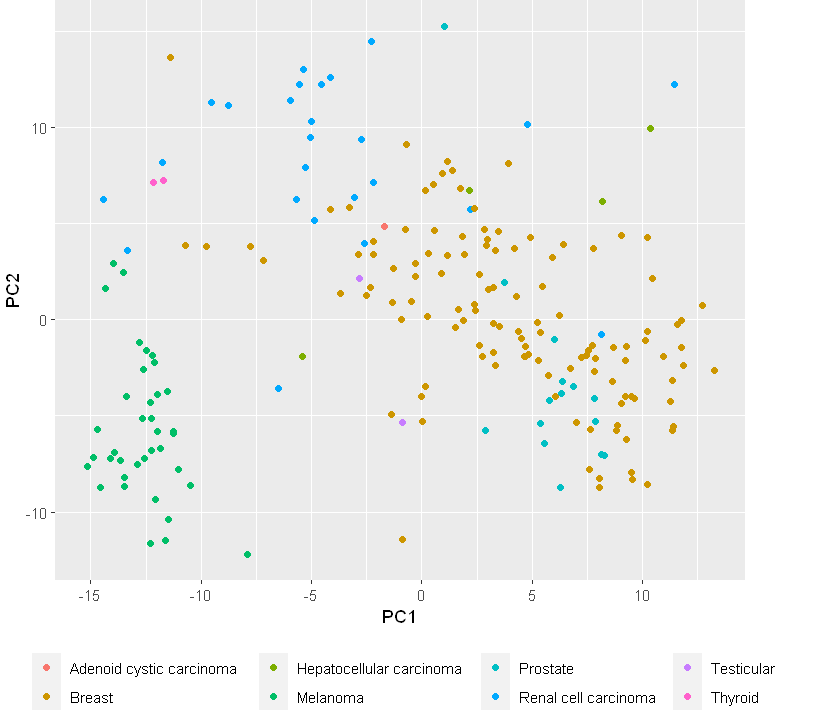

In [38]:
# plot
options(repr.plot.width = 7, repr.plot.height = 6)  # set figure size
ggplot(pca_plot, aes(x = PC1, y = PC2)) + 
    geom_point(aes(color = tumor_type)) +
    theme(legend.position = "bottom",
          legend.title = element_blank(),
          plot.margin = unit(c(0,2,0,0.1), "cm"))

## ICA

In [43]:
updateR()

ERROR: Error in updateR(): could not find function "updateR"


## UMAP

In [19]:
umap_out <- umap(log_tpm)
umap_out

umap embedding of 207 items in 2 dimensions
object components: layout, data, knn, config


In [20]:
head(umap_out$layout, 3)

CTG-3501,1.744834,-1.153910
CTG-0718,-2.385153,4.714008
CTG-1181,1.279266,2.670678


In [42]:
# join the output with the original dataframe to have tumor_type
umap_plot <- data.frame(UMAP1 = umap_out$layout[,1], 
                        UMAP2 = umap_out$layout[,2], 
                        model = rownames(umap_out$layout)) %>% 
    inner_join(df, by="model")

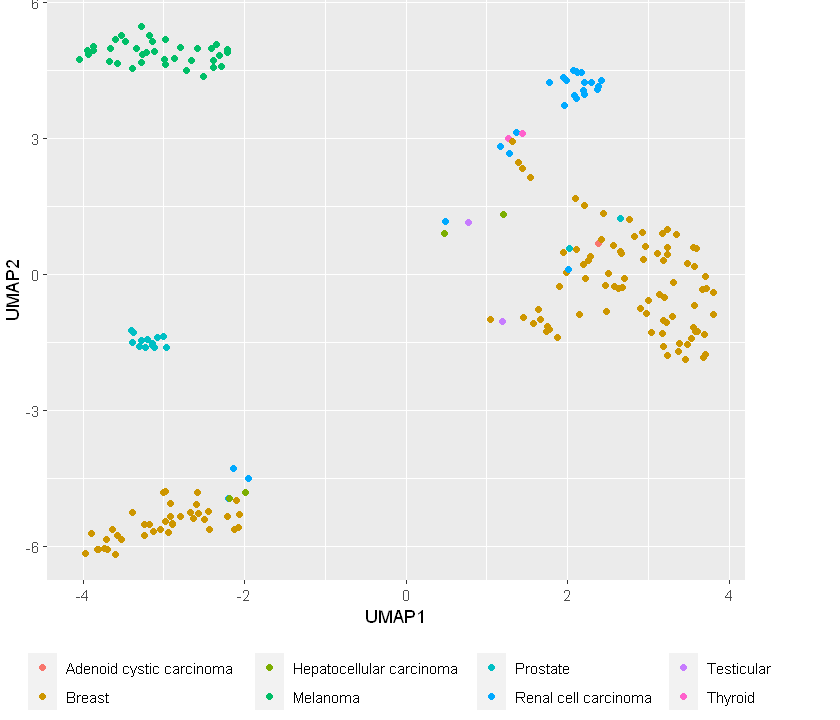

In [22]:
# plot
options(repr.plot.width = 7, repr.plot.height = 6)  # set figure size
ggplot(umap_plot, aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = tumor_type)) +
    theme(legend.position = "bottom",
          legend.title = element_blank(),
          plot.margin = unit(c(0,2,0,0.1), "cm"))

# breast cancer are in two clusters because breast cancer has distinct subtypes